# Machine Learning

## Set up

In [32]:
!pip install lightgbm

In [131]:
# Set up folders
from EDA_functions import folders_set_up
import os

# Work with datarames
import pandas as pd
import numpy as np

# Charts
import seaborn as sns
from matplotlib import pyplot as plt

# X, Y preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Light GBM
# import lightgbm as lgb

# Random Forest
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree

# Neural Network
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Dropout
from keras.optimizers import Adam, SGD

# Pipeline
from sklearn.pipeline import Pipeline

# Evaluate models
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

### Folders
Run the code below if you have the following structure:
- Group-project: GitHub folder
- 01 Input
- 02 Output

In [34]:
analysis_folder, input_folder, output_folder = folders_set_up.generate_folders()

## Import and merge data

### Datasets

In [35]:
#Title-level dataset
titles_df = pd.read_pickle(
    os.path.join(output_folder, 'English_fiction_pre_PCA_3_with_embeddings')
)

titles_df.columns

Index(['Title', 'description', 'authors', 'image', 'previewLink', 'publisher',
       'infoLink', 'categories', 'reviews number', 'average rating',
       'median rating', 'min review date', 'max review date',
       'weighted rating', 'date', 'year', 'description_language', 'Embedding'],
      dtype='object')

In [36]:
# indices are missing in the file above, we get them from another dataset
index_df = pd.read_csv(
    os.path.join(output_folder, 'English_fiction_pre_PCA_3.csv')
)

index_df = index_df[['Title', 'index']]

In [37]:
# NLP
# descriptions_df

### Merge

In [38]:
# Merge titles dataframe with indices dataframe

df = pd.merge(
    titles_df,
    index_df,
    on = 'Title',
    how = 'left'
)

df.columns

Index(['Title', 'description', 'authors', 'image', 'previewLink', 'publisher',
       'infoLink', 'categories', 'reviews number', 'average rating',
       'median rating', 'min review date', 'max review date',
       'weighted rating', 'date', 'year', 'description_language', 'Embedding',
       'index'],
      dtype='object')

In [39]:
# Merge titles dataframe and description PCA

# df = pd.merge(
#     titles_df,
#     descriptions_df,
#     on = 'index',
#     how = 'left'
# )

### Format data

In [40]:
df.dtypes

Title                    object
description              object
authors                  object
image                    object
previewLink              object
publisher                object
infoLink                 object
categories               object
reviews number            int64
average rating          float64
median rating           float64
min review date          object
max review date          object
weighted rating         float64
date                     object
year                    float64
description_language     object
Embedding                object
index                     int64
dtype: object

#### Date

In [41]:
dates_columns = ['min review date', 'max review date', 'date']

for date in dates_columns:
    # get date from strings with time
    df[date] = df[date].str.split().str[0]
    # convert in datetime
    df[date] = pd.to_datetime(df[date])

In [42]:
df[dates_columns].isna().sum()

min review date    0
max review date    0
date               0
dtype: int64

In [43]:
# NOTE: we work on a subset of data for now to make the ML run faster
df = df.sample(n=1000, random_state=42)

#### Author and publisher

In [44]:
df[['authors', 'publisher']]

,authors,publisher
18094,['Hilda Stahl'],Thomas Nelson Incorporated
9755,['James Hadley Chase'],Murder Room
21240,['Ian Bone'],Simon and Schuster
6725,['Cara Black'],Soho Press
8882,['Virginia Macgregor'],Sphere
...,...,...
12461,['Janette Oke'],Bethany House
20793,['John Peel'],Macmillan
19318,['Sebastian Faulks'],Vintage
6087,['Gilbert Morris'],Tyndale House Pub


In [63]:
# Function to convert all strings to lower case and strip names of spaces
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", "").replace("[", "").replace("]", "").replace("'", "").replace('"', ''))
        else:
            return ''

In [51]:
prova = df['authors'].iloc[0]


In [64]:
# Apply clean_data function to your features.
features = ['authors']

for feature in features:
    df[feature] = df[feature].apply(clean_data)

In [65]:
df[['authors', 'publisher']]

,authors,publisher
18094,hildastahl,Thomas Nelson Incorporated
9755,jameshadleychase,Murder Room
21240,ianbone,Simon and Schuster
6725,carablack,Soho Press
8882,virginiamacgregor,Sphere
...,...,...
12461,janetteoke,Bethany House
20793,johnpeel,Macmillan
19318,sebastianfaulks,Vintage
6087,gilbertmorris,Tyndale House Pub


In [66]:
df['authors'].value_counts()

authors
arthurconandoyle               4
louislamour                    4
r.l.stine                      4
carolynkeene                   4
agathachristie                 4
                              ..
siegfriedsassoon               1
dominiquelapierre              1
jackkerouac                    1
allanseager                    1
elizabethvonarnim,elizabeth    1
Name: count, Length: 917, dtype: int64

In [67]:
for feature in features:
    df = pd.get_dummies(df, columns = [feature])

### Clean data
Most of the cleaning is done in '02 Consolidate books dataset':
- English description
- category containing the word 'fiction'
- non-missing date
- non-missing author
- non-missing publisher
- non-missing cover image

## X and y set up

### Train test split

In [82]:
# Create X and y including all X features and all all teh possible target variables
# NOTE: we will have to add the description PCA in X_features
columns_to_drop = ['Title', 'description', 'image', 'previewLink',
       'infoLink', 'categories', 'reviews number', 'average rating',
       'median rating', 'min review date', 'max review date',
       'weighted rating', 'date', 'description_language',
       'index',
       'publisher']

X = df.drop(columns_to_drop, axis = 1)
y = df[['average rating', 'weighted rating']]

In [83]:
# Create train test split

# Need to create train test split for different combinations of data
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size= 0.2, 
    random_state= 42,
)

In [84]:
# We are going to run two models for two target variables
# - Target variable: Average rating
#   - baseline (i.e. excluding image embeddings)
#   - including image embeddings
# - Target variable: weighted rating
#   - baseline (i.e. excluding image embeddings)
#   - including image embeddings

# We therefore need to create the following datsets
# - X train and X test with embeddings
# - X train and X text without embeddings
# - y train and y test using average rating
# - y train and y test using weighted rating

X_baseline_train = X_train.drop('Embedding', axis = 1)
X_baseline_test = X_test.drop('Embedding', axis = 1)
X_images_train = X_train
X_images_test = X_test

y_avg_r_train = y_train['average rating']
y_avg_r_test = y_test['average rating']

y_wr_train = y_train['weighted rating']
y_wr_test = y_test['weighted rating']

In [85]:
X_baseline_train.shape

(800, 918)

### Scale variables

No need to scale variables for now

## Lightgbm

## SVC

In [150]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score

# Step 3: Create an instance of the SVC model with a non-linear kernel
svc_model = SVR(kernel='rbf')  # 'rbf' for radial basis function kernel

# Step 4: Fit the model to your training data
svc_model.fit(X_baseline_train, y_wr_train)

# # Step 5: Evaluate the model (optional)
y_wr_pred = svc_model.predict(X_baseline_test)
mse = mean_squared_error(y_wr_test, y_wr_pred)
print("MSE:", mse)

# # Step 6: Use the model for predictions
# # You can now use the trained model (svc_model) to make predictions on new data


MSE: 0.048182160331453616


## Random forest

-> Questions/notes:
- any hyperparameter we need to think about?
- which metric are we using to evaluate the model?

### Set up

In [86]:
# Set up RF
rf = RandomForestRegressor()

### Train model

In [136]:
x_df = pd.DataFrame({
    "baseline": {'train': X_baseline_train, 'test': X_baseline_test, 'predictions' : None, 'MAE': None, 'MSE' : None},
    "book_covers" : {'train': X_images_train, 'test': X_images_test,  'predictions' : None, 'MAE': None, 'MSE' : None}}).transpose()
x_df

,train,test,predictions,MAE,MSE
baseline,year authors_abrahammerritt authors...,year authors_abrahammerritt authors...,None,None,None
book_covers,year ...,year ...,None,None,None


In [138]:
for i, model in x_df.iterrows():
    print(i)

    # Train dataset
    rf.fit(x_df.loc[i, 'train'], y_wr_train)
    print("fit done")


    # Calculate predictions
    y_wr_pred = rf.predict(x_df.loc[i, 'test'])
    print("predictions done")

    # Calculate MAE and MSE
    mse = mean_squared_error(y_wr_test, y_wr_pred)
    mae = mean_absolute_error(y_wr_test, y_wr_pred)

    # Print MAE and MSE
    print("Mean Squared Error:", mse)
    print(f"Mean Absolute Error: {mae: .2%}")

    # Store predictions
    x_df.loc[i, 'predictions'] = y_wr_pred
    x_df.loc[i, 'MAE'] = mae
    x_df.loc[i, 'MSE'] = mse
    print("results stored")
    print("")



baseline
fit done
predictions done
Mean Squared Error: 0.052191743064725744
Mean Absolute Error:  13.85%
results stored

book_covers


ValueError: setting an array element with a sequence.

In [139]:
# Fit data
rf.fit(X_images_train, y_wr_train)

ValueError: setting an array element with a sequence.

### Predict

In [100]:
# Make predictions
y_wr_pred = rf.predict(X_images_train)

### Evaluate model

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Assuming y_true are the true target values and y_pred are the predicted values by your model
mse = mean_squared_error(y_wr_test, y_wr_pred)
mae = mean_absolute_error(y_wr_test, y_wr_pred)

print("Mean Squared Error:", mse)
print(f"Mean Absolute Error: {mae: .2%}")

Mean Squared Error: 0.052386046238922256
Mean Absolute Error:  13.87%


### Feature importance

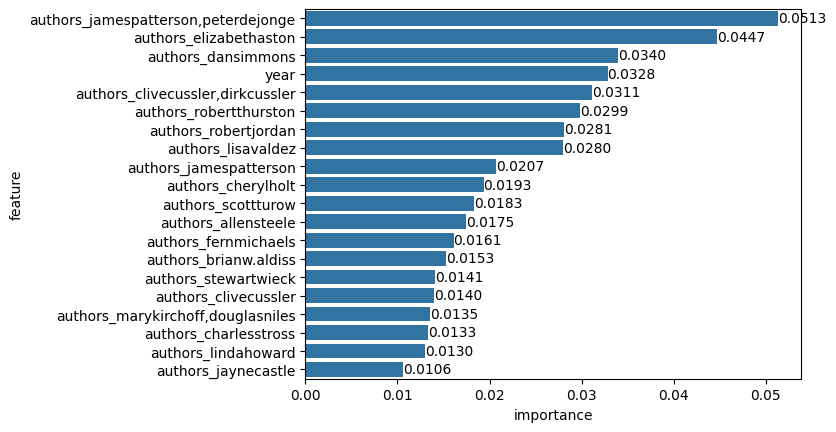

In [98]:
# Display the feature importance.

# get importance of features and assign names
rf_importances = rf.feature_importances_
rf_importances = pd.DataFrame({'feature':X_baseline_test.columns, 'importance': rf_importances})
# sort dataset by importance
rf_importances = rf_importances.sort_values(by = 'importance', ascending = False)
rf_importances = rf_importances.head(20)

# Draw chart
ax = sns.barplot(
    data = rf_importances,
    x = 'importance',
    y = 'feature'
)

for index, value in enumerate(rf_importances['importance']):
    ax.text(value, index, f'{value:.4f}', ha='left', va='center', fontsize=10)

In [99]:
rf_importances

,feature,importance
409,"authors_jamespatterson,peterdejonge",0.051304
262,authors_elizabethaston,0.044720
194,authors_dansimmons,0.033990
0,year,0.032822
176,"authors_clivecussler,dirkcussler",0.031087
750,authors_robertthurston,0.029870
743,authors_robertjordan,0.028099
567,authors_lisavaldez,0.027981
407,authors_jamespatterson,0.020712
153,authors_cherylholt,0.019344


### Decision tree of the forest

In [ ]:
# #Using a decision tree with a max_leaf_nodes of 3, plot the decision tree

# dt_max_3 = DecisionTreeRegressor(max_depth=3)
# dt_max_3.fit(X_train,y_train)
# dt_max_3_predictions = dt_max_3.predict(X_test)

# fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (10,10), dpi=300)
# tree.plot_tree(
#     dt_max_3,
#     max_depth = 3, 
#     feature_names=X_train.columns,  
#     class_names=True,
#     filled=True,
#     fontsize=8
# )
# plt.show()


## Neural Network

-> Questions/notes:
Inputs to choose:
- number of layers
- activation functions
- Use softmax in the last layer to obtain the probability distribution of the outcome?
- optimizer: Adam? sdg?
- loss function
- add dense layers to avoid overfitting?
- number of epochs
- which metric to use to evaluate the model?

- Use gridsearch to optimise hyperparameters?

### Set up

In [ ]:
# get number of inputs - second element of shape (i.e. number of columns in X)
input_shape = X.shape[1]

# neurons number
n_neurons = 512

# define a model
model = keras.Sequential()

# Add input layer
model.add(layers.Dense(
            n_neurons, # number of neurons
            input_dim = input_shape, # number of inputs 
            activation = 'tanh' # activation faunction
            ))

# Hidden - Layers
model.add(layers.Dropout(0.3, noise_shape=None, seed=None))
model.add(layers.Dense(50, activation = "relu"))
model.add(layers.Dropout(0.2, noise_shape=None, seed=None))
model.add(layers.Dense(50, activation = "relu"))

# To change activation function: Output: only want one neuron in the last layer = no activation because we want an output that is a continuous variable (same as saying activation = linear)
model.add(layers.Dense(1, activation = 'linear'))

model.summary()

### Compile

In [ ]:
# Compile model

# Concrete and wine datasets (output is continuous variable)
model.compile(
    optimizer='sgd', 
    loss='mean_squared_error', 
    metrics=['mae'])

# Shallow Network (numbers recognition - output is categorical var)
model.compile(
    loss='categorical_crossentropy',
    optimizer=SGD(learning_rate=0.01),  # lr = learning rate
    metrics=['accuracy']
)

# Auto purchase dataset (y is continuous)
model.compile(
    optimizer='adam',
    loss='mean_squared_error')

### Tune model?

In [ ]:
# Grid search?

### Train model

-> Note:
- this will have to be done including and excluding images

In [ ]:
# Train model
epochs_hist = model.fit(
    X_train, # input
    y_train, # output
    epochs=100, # number of iterations
    batch_size=50, # number of observations taken to train the data - 1030 obs/50 -> there are 17 groups (observations are taken once for epoch) so model is trained 17 times in each epoch
    verbose=1,
    validation_data = (X_test, y_test),
    shuffle = True
    #validation_split=0.2,    
)

### Predict

In [ ]:
# Predict
y_pred = model.predict(X_test)

### Evaluate model

In [ ]:
# evaluate the model (it will give the metric specified when model is compiled)
score = model.evaluate(
    X_test,
    y_test,
    verbose=1
)

In [ ]:
# Visualise NN

# Plotting Loss And Root Mean Square Error For both Training And Test Sets
plt.plot(epochs_hist.history['mae'])
plt.plot(epochs_hist.history['val_mae'])
plt.title('MAE')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(epochs_hist.history['loss'])
plt.plot(epochs_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('4.png')
plt.show()

In [ ]:
# Interpretation of model performance - example with y continuous
test_predictions_ = model.predict(test_df).flatten()
test_labels_ = test_labels.to_numpy().flatten()

_, ax = plt.subplots(figsize=(14,8))
plt.scatter(
    test_labels_,
    test_predictions_,
    alpha=0.6,
    color='#ff7043',
    lw=1,
    ec='black'
)

lims = [
    0,
    max(test_predictions_.max(), test_labels_.max())
]

plt.plot(lims, lims, lw=1, color='#00acc1')
plt.tight_layout()
plt.show()

## Set up pipeline

-> Questions/notes:
- how to integrate NN in the pipeline?

In [ ]:
# Example
# Define pipeline steps
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Feature scaling
    ('rf', rf)  # Random Forest classifier
])

nn_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Feature scaling
    ('nn', model)  # Neural Network classifier
])

# Fit Random Forest pipeline
rf_pipeline.fit(X_train, y_train)

# Fit Neural Network pipeline
nn_pipeline.fit(X_train, y_train)

# Evaluate models
rf_accuracy = rf_pipeline.score(X_test, y_test)
nn_accuracy = nn_pipeline.score(X_test, y_test)

print("Random Forest Accuracy:", rf_accuracy)
print("Neural Network Accuracy:", nn_accuracy)


## Cross validation